# Sparse tensors

A new functionality of Tensor Fox is the support for sparse tensors. Let $T \in \mathbb{R}^{I_1 \times \ldots \times I_L}$ ba a sparse tensor with *nnz* nonzero entries. The tensor is represented as a triple [*data, idxs, dims*], where *data* is an array of size $nnz$ such that *data[i]* is the $i$-th nonzero entry of $T$, with corresponding index *idxs[i]*. It is necessary to pass *idxs* also as an array, which will be of shape $nnz \times L$. Finally, we have that *dims* $= [I_1, \ldots, I_L]$. 

Below we create a fourth order sparse tensor $10 \times 10 \times 10 \times 10$ with only 6 nonzero entries. These entries are random and are located in random places of $T$. 

In [1]:
import numpy as np
import TensorFox as tfx
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Initial variables.
nnz = 6
n = 10
dims = (n, n, n, n)
L = len(dims)

# Create the nonzero values of T.
data = np.random.randn(nnz)

# Create indexes.
idxs = np.zeros((nnz, L), dtype=np.int64) 
for l in range(L):
    idxs[:, l] = np.random.randint(0, dims[l], size=(nnz))

# Define sparse tensor.
T = [data, idxs, dims]

Here we prefer the damped Gauss-Newton method to compute the CPD, but the Tensor Train CPD also works. We remark that it is not possible to use $\verb|tol| \_ \verb|mlsvd| = 0$ or $-1$ since these options doesn't perform compression and to work with large tensors as $T$ we must always to compress. It is important to note that setting $\verb|display| = 3$ or $4$ forces the program to compute the errors in the original space, and to make this it is necessary to work with dense tensors. The memory reduction allowed by the sparse representation is totally lost in this case.

In [3]:
class options:
    display = 2
    method = 'dGN'
    
R = 6
factors, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (10, 10, 10, 10) to (6, 5, 6, 5)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error |  Step size  | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 1.08e+01  |  2.36e-01   |  1.08e+01   |  1.12e+03  |    1.06e-06     |        3        
        2     | 3.76e+00  |  2.32e-01   |  7.04e+00   |  1.59e+02  |    2.62e-07     |        5        
        3     | 1.50e+00  |  2.51e-01   |  2.27e+00   |  2.30e+01  |    1.49e-05     |        5        
        4     | 8.18e-01  |  3.59e-01   |  6.80e-01   |  3.10e+00  |    1.58e-04     |        7        
        5     | 4.77e-01  |  4.42e-01   |  3.41e-0

The relative error showed above only take in account the nonzero entries of $T$. The factor matrices of the decomposition may introduce small errors when approximating the zeros, and this small errors summed together does increase the actual error of the CPD. Thus the relative error showed above is a lower bound to the actual error, but usually it is close enough.

Since this is a small example we can put everything in dense format and verify what is the actual error. However this won't be possible for really large tensors. Regardless, the main point of the CPD is to approximate the nonzero entries, which is done.

In [4]:
# Generate the coordinate (dense) format of the approximation.
T_approx = tfx.cnv.cpd2tens(factors)

# Generate the dense format from the sparse representation.
T_dense = tfx.cnv.sparse2dense(data, idxs, dims)

# Compute the error.
np.linalg.norm(T_dense - T_approx)/np.linalg.norm(T_dense)

2.1235758235171566e-07

There is a big reduction in memory cost when working with sparse representations. Below we show a graph with the maximum memory cost attained in the computation of the CPDs of sparse $n \times n \times n$ tensors (blue curve) vs. the cost to store these tensors in dense format. As we can see, the difference is substantial. For instance, the sparse approach requires $3648$ megabytes when $n = 30000$, whereas the dense approach requires approximately $205$ terabytes. 

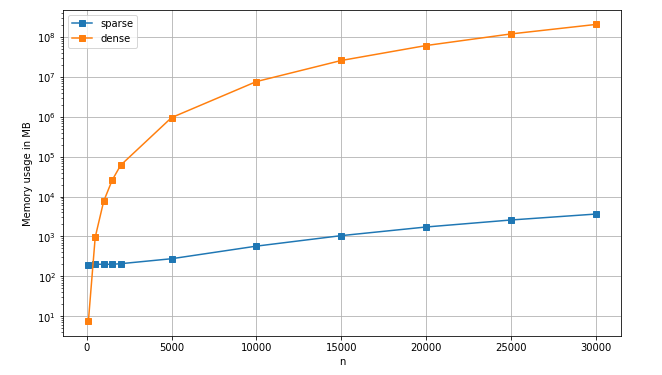

In [5]:
Image("sparse.png")

We finish this lecture showing an example of a third order tensor with shape $10^6 \times 10^3 \times 10^2$, where all nonzero entries are in the first row of the tensor. This means this tensor can be regarded as a matrix embedded in a bigger structure. 

In [6]:
# Initial variables.
nnz = 10
dims = (1000000, 1000, 100)
L = len(dims)

# Create the nonzero values of T.
data = np.random.randn(nnz)

# Create indexes.
idxs = np.zeros((nnz, L), dtype=np.int64) 
for l in range(L):
    idxs[:, l] = np.random.randint(0, dims[l], size=(nnz))
    
# Let's make the first entry equal to 0 for all indexes.
for i in range(nnz):
    idxs[i, 0] = 0

# Define sparse tensor.
T = [data, idxs, dims]

In [7]:
R = 10
factors, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (1000000, 1000, 100) to (1, 10, 10)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error |  Step size  | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 6.39e+00  |  2.17e-01   |  6.39e+00   |  3.55e+02  |    1.55e-02     |        2        
        2     | 3.33e+00  |  1.28e-01   |  3.06e+00   |  1.04e+02  |    2.14e-03     |        3        
        3     | 1.18e+00  |  1.73e-01   |  2.14e+00   |  3.30e+01  |    2.91e-03     |        3        
        4     | 6.74e-01  |  9.81e-02   |  5.10e-01   |  4.95e+00  |    6.22e-03     |        3        
        5     | 5.19e-01  |  6.08e-02   |  1.55